In [1]:
%pip install yfinance numpy pandas tensorflow[and-cuda] matplotlib scikit-learn keras-tuner ipympl
import json
import numpy as np
import os
import locale
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

# Data Source
import yfinance as yf
import matplotlib.pyplot as plt

from stock_modules.stock_io import (read_tickers_from_excel,
                                    get_histories)

# Figures
from stock_modules.stock_plot import plot_numpy_arr_cols
if not os.path.exists("./figures"):
    os.mkdir("./figures")

# test GPU found
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Note: you may need to restart the kernel to use updated packages.


2023-12-04 21:28:05.420037: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 21:28:05.420111: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 21:28:05.467693: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 21:28:05.566639: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 21:28:06.492801: W tensorflow/compiler/tf2

Num GPUs Available:  1


2023-12-04 21:28:08.168882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 21:28:08.338006: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-04 21:28:08.338200: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
ENCODING = locale.getpreferredencoding()
DF_PATH = "HEL_12-10-21to08-11-23.csv"
HISTORY_ARRAY_PATH = "./histories_arr.npy"
MODEL_PATH = "./keras-tuner-dir"
SELECTED_TICKERS_PATH = "./TICKERS_TO_FOLLOW.json"
SELECTED_TICKERS = json.load(open(SELECTED_TICKERS_PATH, "r", encoding=ENCODING))
DATAFRAME = pd.read_csv(DF_PATH, encoding=ENCODING)
DATAFRAME.set_index("date", inplace=True)
HAS_TIMEDELTA = "Time Delta" in DATAFRAME.columns
# ind transformation tells the label of each index in the np_arr_test
IND_CONVERSION = {i: ticker for i, ticker in enumerate(DATAFRAME.columns) if ticker in SELECTED_TICKERS}
IND_CONVERSION = {i: ticker for i, ticker in enumerate(IND_CONVERSION.values())}
print("Selected tickers: \n", SELECTED_TICKERS)
print("Dataframe shape: ", DATAFRAME.shape)
print(f"Index conversion: \n")
for k, v in IND_CONVERSION.items():
    print(f"{k}: {v}")
print(f"Using Time Delta: {HAS_TIMEDELTA}")
    

Selected tickers: 
 ['ALBBV.HE', 'CGCBV.HE', 'EQV1V.HE', 'KNEBV.HE', 'ORNBV.HE', 'OLVAS.HE', 'DETEC.HE', 'PON1V.HE', 'ORNAV.HE', 'VALMT.HE', 'NESTE.HE', 'HUH1V.HE', 'REG1V.HE', 'VAIAS.HE']
Dataframe shape:  (4389, 14)
Index conversion: 

0: REG1V.HE
1: NESTE.HE
2: ORNBV.HE
3: KNEBV.HE
4: OLVAS.HE
5: HUH1V.HE
6: DETEC.HE
7: ORNAV.HE
8: CGCBV.HE
9: VAIAS.HE
10: ALBBV.HE
11: VALMT.HE
12: EQV1V.HE
13: PON1V.HE
Using Time Delta: False


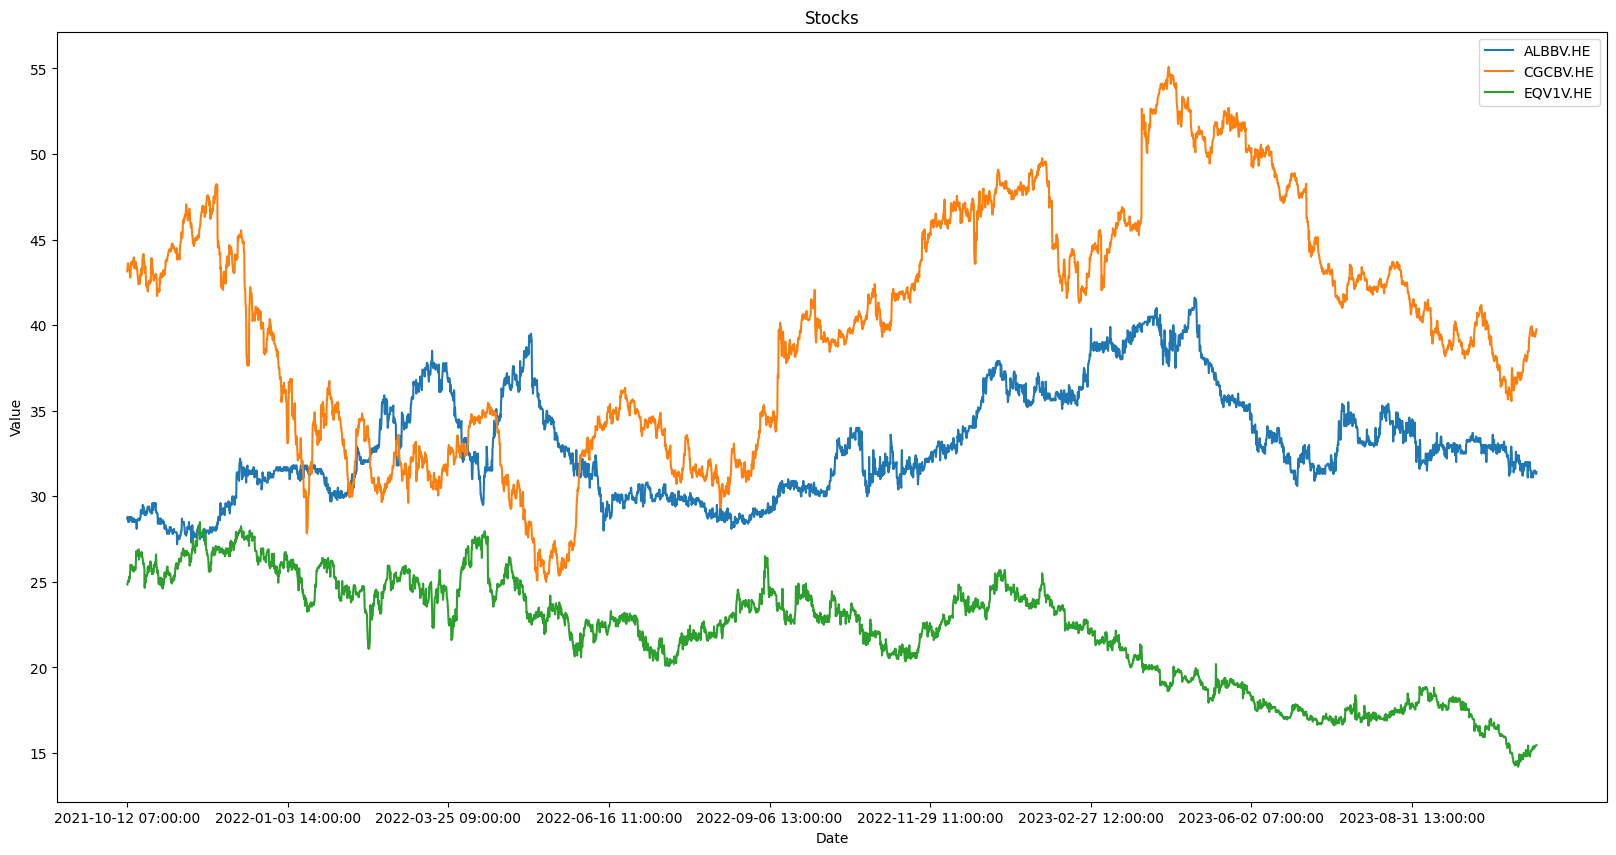

In [3]:
# Show values or not
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Stocks")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
for ticker in SELECTED_TICKERS[:3]:
    ax.plot(DATAFRAME.index, DATAFRAME[ticker], label=ticker)
# Change xticks
ax.set_xticks(DATAFRAME.index[::500])
ax.legend()
plt.show()

In [4]:
# If we are predicting the next price, we just minmax scale the data
TEST_FRAC = 0.2

df = DATAFRAME.copy()
if HAS_TIMEDELTA:
    td_col = df["Time Delta"]
    df.drop("Time Delta", axis=1, inplace=True)
diff_df = df.diff()
# The first row is NaN, so lets copy the second row there
diff_df.iloc[0, :] = diff_df.iloc[1, :]
# Add back the Time Delta column
if HAS_TIMEDELTA:
    diff_df["Time Delta"] = td_col
    # Make Time Delta the first column
    cols = diff_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    diff_df = diff_df[cols]
transformed_df = diff_df

# Now the transformed_df contains the data that is input to the model
# The original price data is in DATAFRAME
print(f"Dataframe shape: {df.shape}")
print(f"Transformed df shape: {transformed_df.shape}")


Dataframe shape: (4389, 14)
Transformed df shape: (4389, 14)


In [5]:
# Reload modules
%load_ext autoreload
%autoreload 2

from stock_modules.stock_transform import create_batch_xy
MHOURS = 48
CHANGE_THRESHOLD = 0.002
def update_global_mhours(new_mhours):
    global MHOURS, X_train, Y_train, X_test, Y_test, X_og, Y_og
    MHOURS = new_mhours
    print(f"MHOURS is now {MHOURS}")
    print(f"Recalculating X and Y data...")
    # Batch X data into sequences of length MHOURS (from T to T+n)
    # Label Y data as 0, 1, 2 for down, flat, up
    # We give the data in the original format, so that the labels can be calculated
    _, Y = create_batch_xy(MHOURS,
                        DATAFRAME,
                        overlap=True,
                        y_updown=False,
                        y_direction=True,
                        threshold=CHANGE_THRESHOLD,
                        to_onehot=True,
                        create_labels=True,
                        )

    # Here instead, we can give the differenced data, because we don't need to calculate the labels
    X,_ = create_batch_xy(MHOURS,
                            transformed_df,
                            overlap=True,
                            create_labels=False,
                            )
    
    rand_indicies = np.random.permutation(X.shape[0])
    X = X[rand_indicies,:,:]
    Y = Y[rand_indicies,:,:]

    # Swap 2nd and 3rd axes in Y to reshape it to (n_samples, 3,nstocks)
    Y = np.swapaxes(Y, 1, 2)

    X_og = X.copy()
    Y_og = Y.copy()

    print(f"X shape: {X.shape}")
    print(f"Y shape: {Y.shape}")

    test_sz = int(X.shape[0] * TEST_FRAC)

    # Split the data into train and test sets
    X_train = X[:-test_sz,:,:]
    Y_train = Y[:-test_sz,:,:]
    X_test = X[-test_sz:,:,:]
    Y_test = Y[-test_sz:,:,:]

update_global_mhours(MHOURS)

print(f"One input shape: {X_train[0].shape}")
print(f"One output shape: {Y_train[0].shape}")

print(f"Example input: \n {X_train[0]}")
print(f"Example output: \n {Y_train[0]}")

# Count the number of ups/downs/flats in Y_train
print(f"Y_train: {Y_train}")
print(f"Number of down classes: {np.sum(Y_train[:,0,:])}")
print(f"Number of flat classes: {np.sum(Y_train[:,1,:])}")
print(f"Number of up classes: {np.sum(Y_train[:,2,:])}")


MHOURS is now 24
Recalculating X and Y data...
[[55.95000076 41.81999969 35.68999863 ... 36.45999908 24.85000038
  39.15000153]
 [55.79999924 41.72000122 35.63000107 ... 36.59999847 24.95000076
  39.20000076]
 [55.70000076 42.06000137 35.40000153 ... 36.40000153 25.
  39.5       ]
 ...
 [22.81999969 31.82999992 36.90999985 ... 22.60000038 15.43999958
  24.        ]
 [22.89999962 31.84000015 37.13000107 ... 22.65999985 15.46000004
  23.70000076]
 [23.02000046 31.89999962 37.18999863 ... 22.78000069 15.46000004
  24.04999924]]

            Batched 'histories_arr' ((4389, 14)) to 'X'
            ((4365, 24, 14)) and 'Y' ((4365, 14, 3))
            
[[-0.15000153 -0.09999847 -0.05999756 ...  0.13999939  0.10000038
   0.04999924]
 [-0.15000153 -0.09999847 -0.05999756 ...  0.13999939  0.10000038
   0.04999924]
 [-0.09999847  0.34000015 -0.22999954 ... -0.19999695  0.04999924
   0.29999924]
 ...
 [-0.04000092  0.29999924  0.00999832 ...  0.01000023  0.0199995
  -0.10000038]
 [ 0.07999992  0.0

In [6]:
from stock_modules.stock_ml import (SkipTDLoss, MultiSoftmaxLoss, MultiAccuracy)
LOSS_FUN = MultiSoftmaxLoss() if not HAS_TIMEDELTA else SkipTDLoss(MultiSoftmaxLoss())


def get_direction_pred_model(hp):
    """ Returns a model that predicts the direction of the stock price.
    """
    # Input shape is (nhours, nstocks)
    input_shape = (MHOURS, X_train.shape[2])
    # Output shape is (3, nstocks)
    output_shape = (3, X_train.shape[2])

    inputs = tf.keras.layers.Input(shape=input_shape)

    nlstm_layers = hp.Int("nlstm_layers", min_value=1, max_value=3, step=1)
    lstm_units = hp.Int("lstm_units", min_value=32, max_value=128, step=32)
    use_bidirectional = hp.Boolean("use_bidirectional")
    # Add LSTM layers
    x = inputs
    for i in range(nlstm_layers):
        if use_bidirectional:
            x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(x)
        else:
            x = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(x)

    # Flatten the output
    ndense_layers = hp.Int("ndense_layers", min_value=1, max_value=3, step=1)
    dense_units = hp.Int("dense_units", min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
    x = tf.keras.layers.Flatten()(x)
    for i in range(ndense_layers):
        x = tf.keras.layers.Dense(dense_units, activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    # Output layer
    outputs = tf.keras.layers.Dense(output_shape[0]*output_shape[1], activation="linear")(x)
    outputs = tf.keras.layers.Reshape(output_shape)(outputs)
    # apply aoftmax to the columns
    outputs = tf.keras.layers.Softmax(axis = 1)(outputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    use_amsgrad = hp.Boolean("use_amsgrad")
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(amsgrad=use_amsgrad),
                    loss=LOSS_FUN,
                    metrics=[MultiAccuracy(has_timedelta=HAS_TIMEDELTA)])
    return model

In [7]:
%load_ext autoreload
%autoreload 2
# Tune the hyperparameters
import keras_tuner as kt

PATIENCE = 20
EPOCHS = 200
BATCH_SIZE = 256
DO_HYPERPARAMETER_TUNING = True

# Create a callback to stop training early
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                patience=PATIENCE,
                                                restore_best_weights=True)

if DO_HYPERPARAMETER_TUNING:
    # Create a tuner
    objective = kt.Objective("val_multi_accuracy", direction="max")
    tuner = kt.Hyperband(get_direction_pred_model,
                        objective=objective,
                        max_epochs=EPOCHS,
                        factor=5,
                        directory=MODEL_PATH,
                        project_name=f"direction_prediction_{MHOURS}"
                        )

    # Train the model
    tuner.search(X_train,
                Y_train,
                epochs=200,
                batch_size=BATCH_SIZE,
                validation_split=0.2,
                callbacks=[early_stopping])

    # Get the best model
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.summary()
    # save the model
    best_model.save("best_model.h5")
    model = best_model
else:
    from stock_modules.stock_ml import create_direction_prediction_model
    # Train a model once
    model = create_direction_prediction_model(MHOURS, X_train.shape[2])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=LOSS_FUN,
                    metrics=[MultiAccuracy(has_timedelta=HAS_TIMEDELTA)]
                    )
    print(model.summary())
    
    model.fit(X_train,
              Y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE, 
              validation_split=0.2,
              callbacks=[early_stopping]
              )

# Evaluate the model
loss, acc = model.evaluate(X_test, Y_test)
print(f"Test loss: {loss}, test accuracy: {acc}")

Y_pred = model.predict(X_test)
if HAS_TIMEDELTA:
    Y_pred = Y_pred[:,1:]




Trial 254 Complete [00h 00m 08s]
val_multi_accuracy: 0.43275997042655945

Best val_multi_accuracy So Far: 0.6508094072341919
Total elapsed time: 01h 16m 08s
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 14)]          0         
                                                                 
 bidirectional (Bidirection  (None, 24, 256)           146432    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 96)                589920    
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                    

/home/ilmari/python/stonk-prediction/.stockvenv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 1s 3ms/step - loss: 0.9196 - multi_accuracy: 0.5841
Test loss: 0.9196210503578186, test accuracy: 0.5840602517127991
28/28 [==============================] - 0s 1ms/step


In [11]:
print("Y_pred: \n", Y_pred)
print("Y_test: \n", Y_test)

# Calculate the accuracy of up-down-flat predictions
# So predict the up/down of each stock, at each time on the test data (Y_pred)
# and compare it to the true values (Y_test)
for stock_idx in range(Y_pred.shape[2] -1 if HAS_TIMEDELTA else Y_pred.shape[2]):
    # Get the up/down/flat predictions for the stock
    direction_preds = Y_pred[:,:,stock_idx]
    #print(f"direction_preds: \n {direction_preds}")
    # Get the true up/down/flat values for the stock
    direction_true = Y_test[:,:,stock_idx]
    # Get the predicted up/down/flat class
    direction_preds = np.argmax(direction_preds, axis=1)
    # Get the true up/down/flat class
    direction_true = np.argmax(direction_true, axis=1)
    # Calculate the accuracy
    accuracy = np.sum(direction_preds == direction_true) / len(direction_preds)
    print(f"Up/Down/Flat accuracy for stock {IND_CONVERSION[stock_idx]}: {accuracy}")


Y_pred: 
 [[[0.36394092 0.765344   0.32159168 ... 0.13497429 0.7682399  0.24913415]
  [0.38281325 0.07596395 0.10739003 ... 0.270264   0.08761019 0.6782374 ]
  [0.25324586 0.15869208 0.5710183  ... 0.59476167 0.14414991 0.07262845]]

 [[0.20805034 0.5495186  0.0913339  ... 0.3445297  0.4207652  0.15534438]
  [0.59513754 0.21352288 0.48181027 ... 0.39216736 0.23011118 0.489525  ]
  [0.19681212 0.23695853 0.4268559  ... 0.26330298 0.3491236  0.35513058]]

 [[0.13114165 0.31270662 0.57654655 ... 0.3555994  0.33802226 0.27533025]
  [0.09911866 0.20032316 0.07203537 ... 0.45994845 0.48108754 0.36502558]
  [0.7697397  0.48697013 0.35141802 ... 0.18445216 0.18089023 0.35964423]]

 ...

 [[0.07258508 0.37017763 0.20293574 ... 0.56709146 0.16850156 0.66812664]
  [0.48955232 0.50416255 0.563228   ... 0.20067257 0.11951347 0.30387625]
  [0.43786263 0.12565976 0.2338363  ... 0.232236   0.71198493 0.02799711]]

 [[0.41301638 0.22340232 0.21555409 ... 0.38717178 0.6309073  0.17154752]
  [0.3378836  

In [12]:

from invest_strategies import (calculate_optimal_invest_strategy,
                               calculate_profit_on_invest_strategy,
                               strategy_mask_from_price_model,
                               strategy_mask_from_updown_model,
                               strategy_mask_from_direction_model)

# Calculate profit by optimal strategy (theoretical) vs using model to predict
test_sz = int(DATAFRAME.shape[0] * TEST_FRAC)
df_test = DATAFRAME.iloc[-test_sz:,:].copy()
if HAS_TIMEDELTA:
    df_test.drop("Time Delta", axis=1, inplace=True)
np_arr_test = df_test.to_numpy()
print("np_arr_test data shape: ", np_arr_test.shape)

optimal_trading_mask = calculate_optimal_invest_strategy(np_arr_test)
print(f"Optimal mask 4th stock: \n {optimal_trading_mask[:,2]}")
profit_optimal = calculate_profit_on_invest_strategy(np_arr_test, optimal_trading_mask)
print(f"Optimal strategy matrix shape: {optimal_trading_mask.shape}")
print(f"Profit by optimal strategy on test data: {profit_optimal}")

# To calculate the mask for the model, we need to give the data in the same format as it was trained in
transformed_df_test = transformed_df.iloc[-test_sz:,:]
transformed_np_arr_test = transformed_df_test.to_numpy()
print("transformed_np_arr_test data shape: ", transformed_np_arr_test.shape)
print(transformed_np_arr_test[0:2,:])
prediction_trading_mask = strategy_mask_from_direction_model(transformed_np_arr_test, MHOURS, model)

if HAS_TIMEDELTA:
    prediction_trading_mask = prediction_trading_mask[:,1:]

print(f"Prediction mask 2nd stock: \n {prediction_trading_mask[:,2]}")
if HAS_TIMEDELTA:
    profit_pred_model = calculate_profit_on_invest_strategy(np_arr_test[:,1:], prediction_trading_mask)
else:
    profit_pred_model = calculate_profit_on_invest_strategy(np_arr_test, prediction_trading_mask)
print(f"Prediction strategy matrix shape: {prediction_trading_mask.shape}")
print(f"Profit by predicting the next hour using the model: {profit_pred_model}")

np_arr_test data shape:  (877, 14)
Optimal mask 4th stock: 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

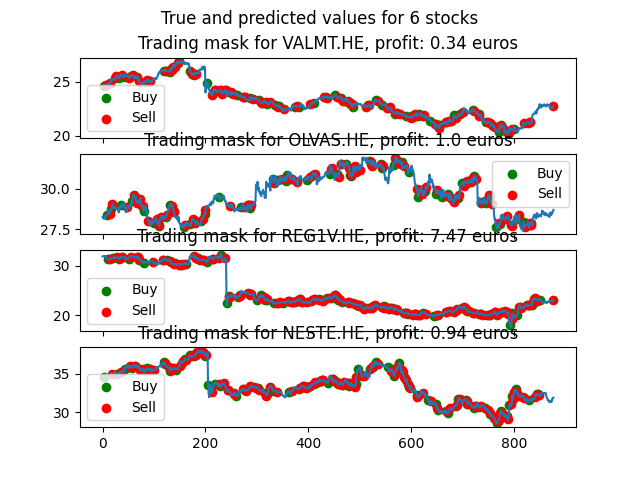

(<Figure size 640x480 with 4 Axes>,
 array([<Axes: title={'center': 'Trading mask for VALMT.HE, profit: 0.34 euros'}>,
        <Axes: title={'center': 'Trading mask for OLVAS.HE, profit: 1.0 euros'}>,
        <Axes: title={'center': 'Trading mask for REG1V.HE, profit: 7.47 euros'}>,
        <Axes: title={'center': 'Trading mask for NESTE.HE, profit: 0.94 euros'}>],
       dtype=object))

In [15]:
%matplotlib widget
from stock_modules.stock_plot import plot_strategy_based_on_predictions,plot_mask_and_data
stock_indices = np.random.choice(np.arange(len(IND_CONVERSION)), 4, replace=False)
part_mask = prediction_trading_mask[:,stock_indices]

if HAS_TIMEDELTA:
    part_price = np_arr_test[:,1:][:,stock_indices]
else:
    part_price = np_arr_test[:,stock_indices]
ind_conversion = {si : IND_CONVERSION[i] for si, i in enumerate(stock_indices)}
plot_mask_and_data(part_mask, part_price, ind_conversion)